In [74]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from joblib import load

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier # used with Linear SVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from multilabel import *
help(multilabel_train_test_split)  # this function will be used later

In [11]:
df = pd.read_csv("train.csv.zip", encoding = "ISO-8859-1")

In [12]:
df_labels = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
print(df_stats)
df_stats_sorted = df_stats.sort_values('number_of_comments', ascending=False)

        category  number_of_comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405


In [13]:
print('Are there missing values in the data?')
print(df.isna().sum())

Are there missing values in the data?
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


Text(0.5, 0, 'category')

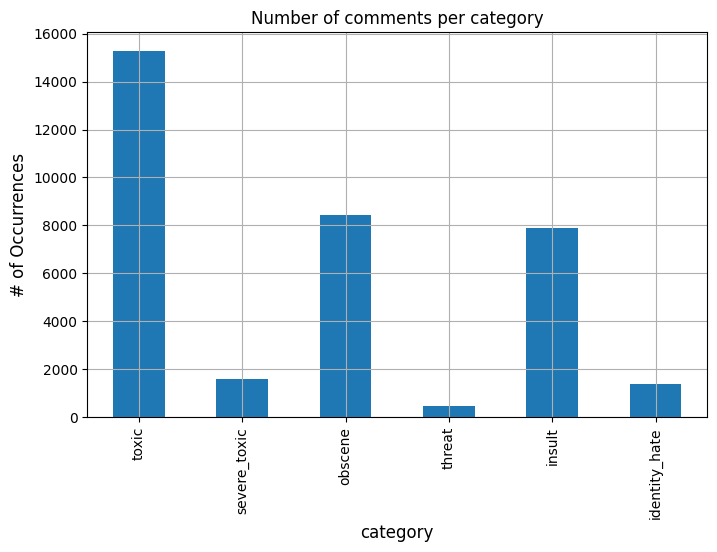

In [14]:

df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Int64Index([0, 1, 3, 2, 4, 5, 6], dtype='int64')
[143346   6360   4209   3480   1760    385     31]


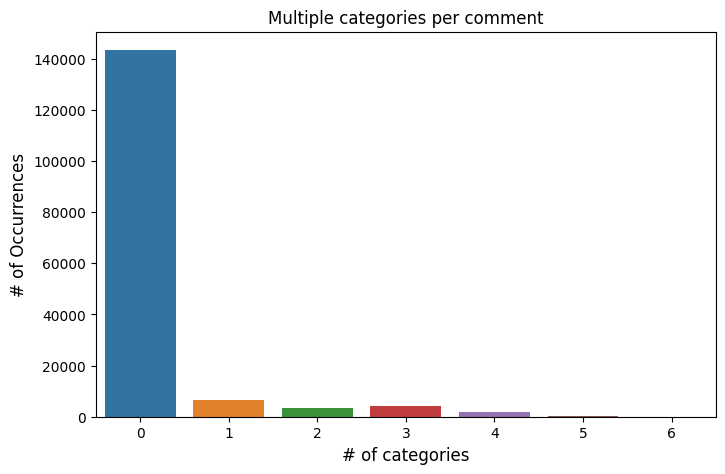

In [15]:

rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
print(x.index)
print(x.values)

#plot
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(x = x.index, y = x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)
plt.show()

In [16]:
def word_count(text):
    words = text.split()
    return len(words)

num_words = []
len_text = []
for text in df['comment_text']:
    num_words.append(word_count(text))
    len_text.append(len(text))

df['num_words'] = num_words
df['text_length'] = len_text

df_labels['num_words'] = num_words
df_labels['text_length'] = len_text

# print(df.head())

<AxesSubplot: >

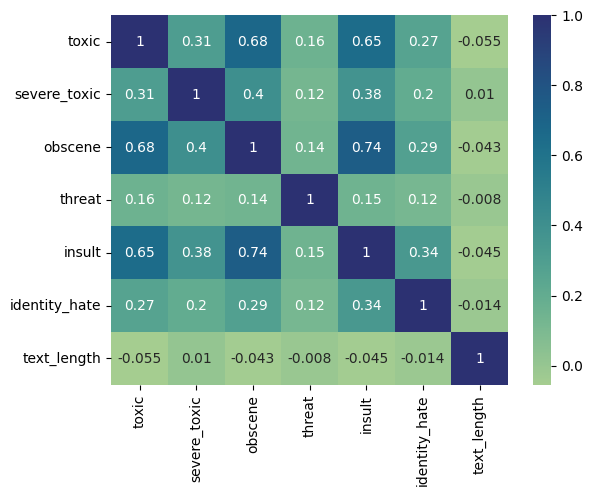

In [17]:
corr_df = df_labels.drop(['num_words'],axis=1).corr()

sns.heatmap(corr_df, annot=True, cmap='crest')

Text(0.5, 1.0, 'Distribution of text lengths')

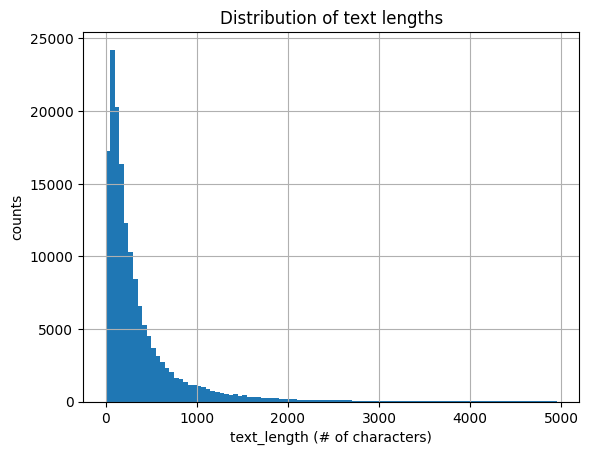

In [18]:

df_labels['text_length'].hist(bins = np.arange(0,5000,50))
plt.xlabel('text_length (# of characters)')
plt.ylabel('counts')
plt.title('Distribution of text lengths')

In [19]:
# Creating boolean filters for each label
# use '~' symbol for the inverse of each filter
toxic_fltr = df['toxic']==1
severe_toxic_fltr = df['severe_toxic']==1
obscene_fltr = df['obscene']==1
threat_fltr = df['threat']==1
insult_fltr = df['insult']==1
identity_hate_fltr = df['identity_hate']==1


print('Percentage of comments that are not labelled:')
print(len(df[~toxic_fltr & ~severe_toxic_fltr & 
             ~obscene_fltr & ~threat_fltr & 
             ~insult_fltr & ~identity_hate_fltr ]) / len(df))



Percentage of comments that are not labelled:
0.8983211235124177


It appears that the majority any toxic comments are labelled toxic first, then a more specific label 'severe_toxic' - 'identity_hate'. What percentage of smaller labels are also labelled 'toxic'?

In [20]:

filter_names = ['severe_toxic' , 'obscene', 'threat' ,'insult' ,'identity_hate' ] 
filters_list = [severe_toxic_fltr, obscene_fltr, threat_fltr, insult_fltr, identity_hate_fltr]

print('Percentage of each:')
for i, fltr in enumerate(filters_list):
    print(filter_names[i] + ' and toxic')
    print(len(df[fltr & toxic_fltr] ) / len(df[fltr] ))

print('Only toxic, no other labels')
print(len(df[toxic_fltr & ~severe_toxic_fltr & 
             ~obscene_fltr & ~threat_fltr & 
             ~insult_fltr & ~identity_hate_fltr] ) / len(df[toxic_fltr] ))   

Percentage of each:
severe_toxic and toxic
1.0
obscene and toxic
0.938099183335306
threat and toxic
0.9393305439330544
insult and toxic
0.9323346451694807
identity_hate and toxic
0.9266903914590747
Only toxic, no other labels
0.3704720805544658


In [21]:
import string

del_punct = string.punctuation
del_punct = del_punct.replace("-", "")  # don't remove hyphens
# del_punct = del_punct.replace(".", "")
# print(del_punct)
rm_pattern = r"[{}]".format(del_punct)

def clean_text(text):
    text = text.lower()  # convert to all lower case
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(rm_pattern, "", text)  # remove punctuations
    text = re.sub(r'[0-9]', ' ', text)  # remove digits 0-9
    text = re.sub('\W', ' ', text)   # removes non-word character
    text = re.sub('\s+', ' ', text)  # removes extra spaces
    
    text = text.strip(' ')
    
    return text

check_clean_text = True
if check_clean_text:
    toxic_comments = df[toxic_fltr]
    for i in range(5):
        print(str(i)+' -----original text-----')
        sample = toxic_comments['comment_text'].iloc[i]
        print(sample[:100])
        print('------cleaned text------')
        clean_sample = clean_text(sample)
        print(clean_sample[:100])

In [27]:
df['cleaned_text'] = df['comment_text'].map(lambda comments : clean_text(comments))

In [83]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

text_for_training = df['cleaned_text']
labels_for_training = df[LABELS]

X_train, X_test, y_train, y_test = multilabel_train_test_split(text_for_training,
                                                               labels_for_training,
                                                               size = 0.25,
                                                               seed = 8)
# X_train, X_test stored as pd.series. y_train and y_test stored as pd.DataFrame

In [36]:
type(X_train)

pandas.core.series.Series

In [24]:
## Old way of doing train_test_split

# train, test = train_test_split(df,  random_state=42, test_size=0.25, shuffle=True)

# X_train = train.clean_text
# X_test = test.clean_text
# print(X_train.shape)
# print(X_test.shape)

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [38]:
# Define a pipeline combining a text feature extractor with multi lable classifier
OVR_NB_pipeline = Pipeline([
                # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [111]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB()),
            ])

In [84]:
OVR_NB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [85]:
# print(type(X_test))
# print(X_test[:2])
y_pred = OVR_NB_pipeline.predict(X_test)
y_proba = OVR_NB_pipeline.predict_proba(X_test)

In [47]:
# print(type(y_pred))
# print(y_pred.shape)
# print(y_pred[:10])
# print(np.round(y_proba[:10],2))

<class 'numpy.ndarray'>
(39892, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.  ]
 [0.77 0.   0.4  0.   0.25 0.  ]
 [0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.1  0.   0.02 0.   0.02 0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.   0.   0.   0.  ]]


In [86]:
y_pred = pd.DataFrame(y_pred, columns=LABELS)
print(y_pred.head())

   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       0              0
3      1             0        0       0       0              0
4      0             0        0       0       0              0


## Precision vs Recall

Precision = TP/(TP+FP)

Recall = TP/(TP+TN)

Having high accuracy is misleading, since positive toxic labels are sparse. The question is, do I want high precision or high recall. Precision is a measure of true positives (correctly labeled toxic comments) relative to false positives (clean comments wrongfully labeled toxic). Recall measures true positives relative to false negatives (toxic comments that were not detected). In other words, do I want to minimize wrongfully labeled clean comments or undetected toxic comments. In my opinion, the former is preferred, since randomly deleting clean comments will upset users. Therefore, high precision is more preferred than high recall.


In [90]:
print(LABELS)
multi_cm = multilabel_confusion_matrix(y_test, y_pred, samplewise=False)

for i in range(multi_cm.shape[0]):
    print(LABELS[i])
    print(mcm[i,:,:])
    
#[[TN, FP],
# [FN, TP]]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic
[[36010     2]
 [ 3188   692]]
severe_toxic
[[39503     0]
 [  389     0]]
obscene
[[37762     4]
 [ 1882   244]]
threat
[[39765     0]
 [  127     0]]
insult
[[37893     2]
 [ 1911    86]]
identity_hate
[[39515     0]
 [  377     0]]


In [59]:
print(classification_report(y_test, y_pred, target_names= LABELS))

               precision    recall  f1-score   support

        toxic       1.00      0.18      0.30      3880
 severe_toxic       0.00      0.00      0.00       389
      obscene       0.98      0.11      0.21      2126
       threat       0.00      0.00      0.00       127
       insult       0.98      0.04      0.08      1997
identity_hate       0.00      0.00      0.00       377

    micro avg       0.99      0.11      0.21      8896
    macro avg       0.49      0.06      0.10      8896
 weighted avg       0.89      0.11      0.20      8896
  samples avg       0.02      0.01      0.01      8896



/home/john/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
save_models = ['toxic_model.sav', 'severe_toxic_model.sav', 'obscene_model.sav', 'threat_model.sav', 'insult_model.sav', 'identity_hate.sav'] 
label_models = ['toxic_model', 'severe_toxic_model', 'obscene_model', 'threat_model', 'insult_model', 'identity_hate'] 

In [80]:
train, test = train_test_split(df,  random_state=42, test_size=0.25, shuffle=True)

# X_train = train['cleaned_text']
X_test = test['cleaned_text']
print(X_train.shape)
print(X_test.shape)


for i, label in enumerate(LABELS):
    file_path = 'saved_models/'+save_models[i]
    loaded_model = pickle.load(open(file_path, 'rb'))
    # compute the testing accuracy
    y_pred_single = loaded_model.predict(X_test)
    y_test_single = test[label]
    # print('Test accuracy is {}'.format(accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test_single, y_pred_single))
    print(classification_report(y_test_single, y_pred_single))

(119678,)
(39893,)


/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[35626   452]
 [ 1576  2239]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     36078
           1       0.83      0.59      0.69      3815

    accuracy                           0.95     39893
   macro avg       0.89      0.79      0.83     39893
weighted avg       0.95      0.95      0.95     39893



/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[39282   205]
 [  240   166]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39487
           1       0.45      0.41      0.43       406

    accuracy                           0.99     39893
   macro avg       0.72      0.70      0.71     39893
weighted avg       0.99      0.99      0.99     39893



/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[37438   312]
 [  927  1216]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     37750
           1       0.80      0.57      0.66      2143

    accuracy                           0.97     39893
   macro avg       0.89      0.78      0.82     39893
weighted avg       0.97      0.97      0.97     39893



/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[39766    22]
 [  101     4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39788
           1       0.15      0.04      0.06       105

    accuracy                           1.00     39893
   macro avg       0.58      0.52      0.53     39893
weighted avg       1.00      1.00      1.00     39893



/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[37487   395]
 [ 1018   993]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     37882
           1       0.72      0.49      0.58      2011

    accuracy                           0.96     39893
   macro avg       0.84      0.74      0.78     39893
weighted avg       0.96      0.96      0.96     39893



/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/john/.local/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your o

[[39444    92]
 [  316    41]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39536
           1       0.31      0.11      0.17       357

    accuracy                           0.99     39893
   macro avg       0.65      0.56      0.58     39893
weighted avg       0.99      0.99      0.99     39893

